# MODEL RSA3
## Pattern Dissimilarity Analyses
### Compares positive derivative to negative derivatives
### Contains only fixed-before-conditional trials without intervening BLs
### Combines A & C trials into single regressor
## ROIs:
### Hippocampus (FS labels: hippocampus [17, 53])
### Dorsal caudate (hand-drawn by Mandy)
### Medial PFC -- Lausanne labels: 
####     - LH -  [1002,1014,1026,1028,1032,1159,1172,1173,1174],
####     - RH - [2002,2014,2026,2028,2032,2159,2172,2173,2174]
### Ventral Occipital (FS labels: fusiform, lingual,  parahippocampal [1007,2007,1013,2013,1016,2016]) 

In [2]:
import os
import re
from os.path import join
from glob import glob
import nibabel as nb
import pandas as pd
import numpy as np
from scipy import stats
from math import sqrt
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_palette('muted')
sns.set_style("white")

sidsX = ['WMAZE_001']
sids = ['WMAZE_001', 'WMAZE_002', 'WMAZE_004', 'WMAZE_005', 'WMAZE_006', 
        'WMAZE_008', 'WMAZE_009', 'WMAZE_010', 'WMAZE_012', #removed 007 for no nonlearn trials
        'WMAZE_017', 'WMAZE_018', 'WMAZE_019', 'WMAZE_020', 'WMAZE_021',  
        'WMAZE_022', 'WMAZE_023', 'WMAZE_024', 'WMAZE_026', 'WMAZE_027']

proj_dir = '/home/data/madlab/Mattfeld_WMAZE/'
masks = [] #list of lists - sublist for each Ss
copes = [] 

for i, SID in enumerate(sids): #iterate through Ss
    masks_glob = glob(proj_dir + 'derivatives/roi_masks/hamm/anat_masks/_subject_id_' + SID + '/_anatmask_xfm*/*')
    masks.append(sorted(masks_glob)) #append sorted ROI masks
    copes_glob = glob(proj_dir + 'Hamm_Learning/RSA3/lvl1/' + SID + '/modelfit/contrasts/_estimate_model*/cope*')
    temp = []
    for j in copes_glob: 
        if 'learn' in j or 'nonlearn' in j: #filter once
            if 'minus' not in j: #filter twice
                temp.append(j)
    copes.append(sorted(temp)) #append sorted 1st level copes
    if len(temp) != 12: #test if all outfiles were created from lvl1
        print SID, len(temp)
print(copes[0][0]) #example cope

/home/data/madlab/Mattfeld_WMAZE/Hamm_Learning/RSA3/lvl1/WMAZE_001/modelfit/contrasts/_estimate_model0/cope02_learn.nii.gz


### Cell to double-check the array indexing for both the masks and the copes

In [3]:
#change first index of cope_files to indicate Ss index in sids array
for i, curr_mask in enumerate(masks[0]):
    print(i, masks[0][i].split('/')[-1][:-7]) 

(0, 'lh-all_mPFC_warped')
(1, 'lh-dlPFC_warped')
(2, 'lh-dmPFC_warped')
(3, 'lh-hippocampus_warped')
(4, 'lh-mPFC_fs-3reg_warped')
(5, 'lh-mPFC_fs_warped')
(6, 'lh-mPFC_lausanne_warped')
(7, 'lh-motor_warped')
(8, 'lh-parsT_warped')
(9, 'lh_caudate_anat_mask_warped')
(10, 'lh_insula_warped')
(11, 'lh_vocc_warped')
(12, 'rh_caudate_anat_mask_warped')
(13, 'rh-all_mPFC_warped')
(14, 'rh-dlPFC_warped')
(15, 'rh-dmPFC_warped')
(16, 'rh-hippocampus_warped')
(17, 'rh-mPFC_fs-3reg_warped')
(18, 'rh-mPFC_fs_warped')
(19, 'rh-mPFC_lausanne_warped')
(20, 'rh-motor_warped')
(21, 'rh-parsT_warped')
(22, 'rh_insula_warped')
(23, 'rh_vocc_warped')
(24, 'lh-putamen_warped')
(25, 'lh_dlpfc_warped')
(26, 'lh_dlpfc_warped')
(27, 'rh-putamen_warped')


In [4]:
for i, curr_cope in enumerate(copes[0]):
    print(i, copes[0][i].split('/')[-2].split('_')[-1], copes[0][i].split('/')[-1][7:-7]) 

(0, 'model0', 'learn')
(1, 'model0', 'nonlearn')
(2, 'model1', 'learn')
(3, 'model1', 'nonlearn')
(4, 'model2', 'learn')
(5, 'model2', 'nonlearn')
(6, 'model3', 'learn')
(7, 'model3', 'nonlearn')
(8, 'model4', 'learn')
(9, 'model4', 'nonlearn')
(10, 'model5', 'learn')
(11, 'model5', 'nonlearn')


### Use binarized mask to obtain activation in left & right hemisphere for each ROI

In [5]:
all_data = {}
for r in ['hp', 'mpfc', 'caud', 'put', 'vocc']: #subdictionary for each region
    all_data['{0}'.format(r)] = {'run1_learn':[], 'run2_learn':[], 'run3_learn':[], 
                                 'run4_learn':[], 'run5_learn':[], 'run6_learn':[],
                                 'run1_nonlearn':[], 'run2_nonlearn':[], 'run3_nonlearn':[],
                                 'run4_nonlearn':[], 'run5_nonlearn':[], 'run6_nonlearn':[]} 
subjid = []
for i in range(len(sids)): #iterate through Ss
    subjid.append(sids[i]) #save current Ss id
    lh_hp_img = nb.load(masks[i][3]) #use nibabel to load regional masks (single-hemisphere)
    rh_hp_img = nb.load(masks[i][16])
    lh_mpfc_img = nb.load(masks[i][5])
    rh_mpfc_img = nb.load(masks[i][18])
    lh_caud_img = nb.load(masks[i][9])
    rh_caud_img = nb.load(masks[i][12])
    lh_put_img = nb.load(masks[i][24])
    rh_put_img = nb.load(masks[i][27])
    lh_vocc_img = nb.load(masks[i][11])
    rh_vocc_img = nb.load(masks[i][23])
    
    run1_learn_img = nb.load(copes[i][0]) #use nibabel to load merged copes
    run1_nonlearn_img = nb.load(copes[i][1]) 
    run2_learn_img = nb.load(copes[i][2])
    run2_nonlearn_img = nb.load(copes[i][3]) 
    run3_learn_img = nb.load(copes[i][4])
    run3_nonlearn_img = nb.load(copes[i][5]) 
    run4_learn_img = nb.load(copes[i][6])
    run4_nonlearn_img = nb.load(copes[i][7]) 
    run5_learn_img = nb.load(copes[i][8])
    run5_nonlearn_img = nb.load(copes[i][9]) 
    run6_learn_img = nb.load(copes[i][10])
    run6_nonlearn_img = nb.load(copes[i][11]) 
   
    for key in all_data: #iterate through subdictionaries (regions)        
        for curr_run in range(6): #iterate through number of runs
            for trialtype in ['learn', 'nonlearn'] : #iterate through learn and nonlearn merged copes
                lh_data = eval('run{0}_{1}_img.get_data()[lh_{2}_img.get_data() > 0.]'.format(curr_run+1,trialtype,key)) 
                rh_data = eval('run{0}_{1}_img.get_data()[rh_{2}_img.get_data() > 0.]'.format(curr_run+1,trialtype,key))
                bihemi_data = np.concatenate((lh_data, rh_data)) #concatenate two hemispheres
                all_data[key]['run{0}_{1}'.format(curr_run+1,trialtype)].append(bihemi_data) #append respective data to dict                       

subjid = pd.Series(subjid) #assign Ss id as row identifier
for key in all_data: #iterate through all region subdicts and create dataframes
    exec('{0}_df = pd.DataFrame(all_data["{0}"]).set_index(subjid)'.format(key))  
all_data_df = pd.DataFrame(all_data) #turn entire super-dict into dataframe  

In [6]:
hp_df #visualize hippocampus masked copes dataframe

,run1_learn,run1_nonlearn,run2_learn,run2_nonlearn,run3_learn,run3_nonlearn,run4_learn,run4_nonlearn,run5_learn,run5_nonlearn,run6_learn,run6_nonlearn
WMAZE_001,"[-14.0641, 7.51946, 70.0358, 7.48472, 56.3937,...","[-15.0408, -0.553772, 48.7063, 6.45907, 52.728...","[-50.4405, -51.0731, -9.25677, -28.3991, 11.71...","[-108.17, -75.0842, -11.2062, -42.8243, 26.727...","[-31.1489, -29.9388, 31.5595, 20.8813, 2.64541...","[-5.31764, -17.4885, 33.2196, 17.0903, -14.706...","[-11.7015, 12.2962, -21.7118, 20.336, 20.0526,...","[-7.45893, 4.36982, -4.46329, 12.4414, 23.2522...","[15.6777, 2.80788, -5.94033, -12.9976, 12.9725...","[13.9708, 18.1096, -11.7895, -0.21105, 41.7073...","[13.5408, 9.00386, 97.7226, 25.2544, 65.5388, ...","[16.102, 10.3073, 69.3964, 29.111, 40.3403, 23..."
WMAZE_002,"[8.56821, -28.3342, 29.3975, 69.5233, -6.47944...","[-28.81, -25.5721, 6.93601, 63.9799, 2.78553, ...","[-25.217, 15.3195, -0.273359, 24.2685, 22.6269...","[-14.4455, 18.1848, -17.7017, 12.6359, 31.4955...","[1.66998, 0.231555, -4.11766, -25.9881, 15.422...","[-43.903, 18.2048, -15.679, -49.0685, 3.5936, ...","[39.3567, 46.6988, 3.47437, 31.4051, 19.8778, ...","[46.5667, 31.8978, -16.7272, 31.9573, 31.8796,...","[-56.4011, 4.7889, 11.6453, -7.54864, -21.5925...","[-83.0534, -1.3108, -23.7958, -21.6817, -29.16...","[55.448, 30.5624, 24.5809, 3.29531, 29.7155, 5...","[59.8787, 54.4538, 3.29543, 17.0412, 37.5024, ..."
WMAZE_004,"[-14.3445, 32.2311, -30.6353, -35.6519, 18.857...","[-35.8183, 40.1041, -4.35221, -35.0989, 31.674...","[44.21, 34.7102, -10.6234, 25.5094, 28.4224, 1...","[32.065, 11.8279, -12.1123, 9.80986, 6.55491, ...","[-16.1331, -35.9275, -17.0497, 20.3105, 6.7800...","[-23.1111, -60.3489, -27.0456, 11.1886, -4.725...","[33.6998, 3.7467, -12.0608, 20.2146, -1.66933,...","[27.947, -7.15663, -27.0668, 12.3628, -21.648,...","[-34.0391, 31.2571, 30.1193, 13.6932, -1.67579...","[-13.4146, 23.8527, 26.0006, 13.0418, -18.9901...","[4.16917, -44.0853, 22.5304, -8.92962, 7.1327,...","[-22.9921, -57.8106, 16.9811, -7.05848, 14.1, ..."
WMAZE_005,"[1.42714, -46.5735, -8.61988, -31.3307, 27.132...","[10.1095, -42.2826, -1.56326, -28.5083, 34.972...","[33.6272, -39.8189, -8.73863, 42.1339, 19.4759...","[16.2244, -49.6571, -1.77768, 55.8514, 23.4886...","[68.4874, -24.6488, 1.22555, -3.12142, 6.0745,...","[84.0871, -27.761, 25.285, 2.91933, -0.465759,...","[31.8525, 19.3436, 20.5321, -9.58892, -8.48975...","[19.9118, 24.3788, 8.45261, -6.23863, -16.401,...","[1.29286, 32.4944, 4.09937, 7.96478, -2.61938,...","[-3.86581, 22.1414, 12.3928, -3.83279, -12.358...","[9.26067, -29.8848, 2.73914, 25.692, 4.45291, ...","[-9.9348, -29.5824, 13.0053, 5.59422, 10.321, ..."
WMAZE_006,"[20.5205, 27.038, -14.2041, 0.607014, 9.60008,...","[19.1546, 28.9366, 8.83195, -6.62452, 14.9745,...","[16.9603, 17.9213, -11.2963, -0.352476, 20.904...","[8.86994, 18.4872, -26.9729, -13.9278, 15.8431...","[-5.82088, -25.0606, -7.02182, -14.5107, 10.26...","[11.4025, -25.5679, 9.31932, -17.2921, -0.0135...","[-16.7478, -5.85018, -19.0885, -50.953, 3.1512...","[-24.9915, 2.50514, -15.8204, -70.7066, 4.8513...","[5.11572, -21.4258, 25.9946, -19.289, -18.0052...","[9.75986, -22.2249, 17.934, -23.7001, -28.2799...","[-15.043, -4.0493, -14.2383, -28.6666, 45.4541...","[-16.2655, -11.579, -5.05007, -23.3635, 5.6781..."
WMAZE_008,"[-12.012, -9.47103, 42.5456, 3.88897, -14.1771...","[4.71946, 2.44977, 45.6438, -27.0382, -46.0761...","[-36.3188, -71.1328, 56.3124, -11.9719, -34.31...","[-26.0287, -43.7554, 71.0286, -10.7438, -46.71...","[7.30511, 41.3851, -38.0019, 35.0123, -4.94091...","[-16.1862, 25.9991, -56.3376, 32.0641, -9.7857...","[12.3526, -11.4796, -31.9571, 30.0568, -12.485...","[-15.3813, -35.3889, -66.4716, 24.6827, -16.21...","[-19.3425, 0.85655, -3.83716, 0.936471, 23.274...","[13.5938, 21.2243, 10.9721, 0.553557, 6.06578,...","[-36.2672, -33.9161, -4.54068, -56.3691, -54.9...","[-20.0039, -46.7393, -12.8779, -43.9427, -32.8..."
WMAZE_009,"[36.1, 16.9027, 83.1451, 46.7515, 

In [7]:
corrs = {} #create dict of 1-correlations (dissimilarity) between activation pattern during learning and nonlearn
for r in ['hp', 'mpfc', 'caud', 'put', 'vocc']:
    corrs['{0}'.format(r)] = {'run1':[], 'run2':[], 'run3':[], 'run4':[], 'run5':[], 'run6':[]}

for x, SID in enumerate(sids): #iterate through Ss
    for key in all_data: #iterate through regions
        for run in range(6): #iterate through runs
            #append 1-correlation between current region/run/cope for current subject
            corrs[key]["run{0}".format(run+1)].append(1-pearsonr(all_data[key]["run{0}_learn".format(run+1)][x],
                                                                 all_data[key]["run{0}_nonlearn".format(run+1)][x])[0])                                
corrs_df = pd.DataFrame(corrs) #convert to dataframe

In [8]:
corrs_df #visualize correlations dataframe

,caud,hp,mpfc,put,vocc
run1,"[0.215723931789, 0.315548658371, 0.18769103288...","[0.138015985489, 0.289933204651, 0.20417046546...","[0.0633479952812, 0.280908942223, 0.1387251019...","[0.273162662983, 0.262140154839, 0.20035678148...","[0.0784425139427, 0.341572284698, 0.0964564085..."
run2,"[0.0901848077774, 0.287795603275, 0.2579498887...","[0.127230167389, 0.306809723377, 0.36910766363...","[0.112007558346, 0.511287361383, 0.24296635389...","[0.103471934795, 0.250303387642, 0.19243717193...","[0.045216023922, 0.173768281937, 0.12406724691..."
run3,"[0.156176865101, 0.203366219997, 0.18778759241...","[0.163501799107, 0.254993677139, 0.20697081089...","[0.129135489464, 0.179086923599, 0.13317894935...","[0.124379515648, 0.219441652298, 0.17468029260...","[0.0571822524071, 0.233986258507, 0.1407579779..."
run4,"[0.280962347984, 0.0741139054298, 0.2353360652...","[0.262123048306, 0.0764176845551, 0.1998537182...","[0.259108126163, 0.0827021002769, 0.2422789335...","[0.283146202564, 0.123673021793, 0.17828887701...","[0.122776687145, 0.0620130896568, 0.0808903574..."
run5,"[0.383082509041, 0.270604908466, 0.15260058641...","[0.593926936388, 0.15480786562, 0.333430767059...","[0.500520765781, 0.205917000771, 0.13712668418...","[0.511723607779, 0.262001335621, 0.29463297128...","[0.176007628441, 0.234917998314, 0.13334441185..."
run6,"[0.170264363289, 0.118044614792, 0.07901966571...","[0.151019275188, 0.110214591026, 0.04367321729...","[0.223389089108, 0.118816375732, 0.04210400581...","[0.228822767735, 0.173073112965, 0.12084716558...","[0.0706769227982, 0.0976978540421, 0.038815021..."


# Performance

In [9]:
prop_corr = {'run1':[], 'run2':[], 'run3':[], 'run4':[],'run5':[], 'run6':[]}

for SID in sids: #iterate through Ss
    sub_dir = '/home/data/madlab/Mattfeld_WMAZE/sourcedata/behav/{0}/'.format(SID)
    run_files = sorted(glob(join(sub_dir,'{0}_wmazebl_2015*.txt'.format(SID)))) #grab 6 run behavior files  
    for i in range(6): #iterate through run files
        run = pd.read_table(run_files[i]) #create dataframe for text files to extract EVS
        run = run[:-3] #removal of the last 3 trials to avoid scanner artifact     
        trialtype = run['TrialType'].values 
        correct = run['Correct'].values
        trial_shift = trialtype[1:] #shift trialtype back 
        trial_shift = np.append(trial_shift, -1) #insert dummy (-1) in last index
        correct_shift = correct[1:]
        correct_shift = np.append(correct_shift, -1)        
        corr = np.where(((trial_shift=='B') & (correct_shift==1)) & (trialtype!='BL'))[0] #indices for correct Bs
        incorr = np.where(((trial_shift=='B') & (correct_shift==0)) & (trialtype!='BL'))[0] #indices for incorrect Bs
        curr_prop_corr = len(corr)/float(len(corr) + len(incorr)) #use len() to get correct proportion of trials
        prop_corr['run{0}'.format(i+1)].append(curr_prop_corr) #append correct proportion        
prop_corr_df = pd.DataFrame(prop_corr).set_index(subjid) #convert to dataframe format and set subject id as row labels

In [10]:
prop_corr_df #visualize performance dataframe

,run1,run2,run3,run4,run5,run6
WMAZE_001,0.520000,0.931034,0.920000,0.888889,0.900000,0.935484
WMAZE_002,0.827586,1.000000,0.965517,1.000000,0.939394,0.964286
WMAZE_004,0.821429,0.960000,0.718750,0.840000,0.774194,0.931034
WMAZE_005,0.636364,0.733333,0.806452,1.000000,0.806452,0.925926
WMAZE_006,0.481481,0.689655,0.793103,1.000000,0.866667,0.937500
WMAZE_008,0.571429,0.777778,0.862069,0.966667,0.730769,0.967742
WMAZE_009,0.720000,0.724138,0.760000,0.827586,0.766667,0.939394
WMAZE_010,0.416667,0.592593,0.500000,0.777778,0.677419,0.500000
WMAZE_012,0.520000,0.703704,0.814815,0.806452,0.800000,0.903226
WMAZE_017,0.571429,0.769231,0.689655,0.826087,0.870968,0.857143


# Hippocampus

run1
Mean run1:  0.254719253433
STD run1:  0.158727248521

run2
Mean run2:  0.239434497921
STD run2:  0.145538561847

run3
Mean run3:  0.201293443379
STD run3:  0.0620552400824

run4
Mean run4:  0.214110663063
STD run4:  0.103616180917

run5
Mean run5:  0.255319579651
STD run5:  0.168167538911

run6
Mean run6:  0.205608684766
STD run6:  0.080830496254

Set1 Run1 vs. Run2:
Wicoxon (86.0, 0.71721779580438849)
Cohen's d =  -0.13816631627


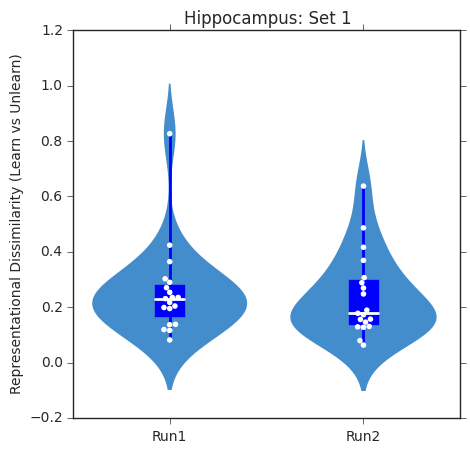

Set2 Run1 vs. Run2:
t-test (0.42539186953111274, 0.67559346466259096)
Cohen's d =  0.206584539618


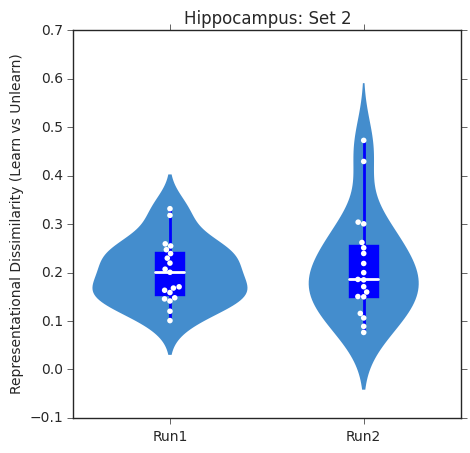

Set3 Run1 vs. Run2:
Wicoxon (74.0, 0.39806292572561963)
Cohen's d =  -0.518638498141


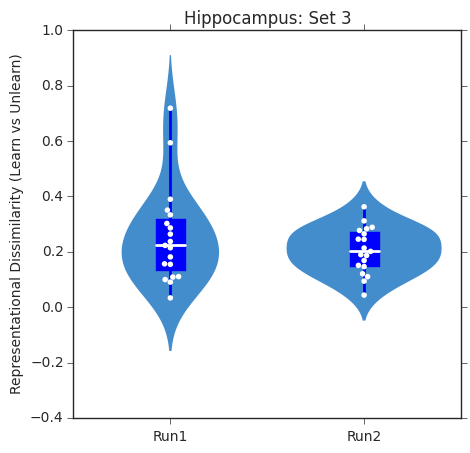

In [21]:
for key in ['run1', 'run2', 'run3', 'run4', 'run5', 'run6']: #provide descriptives for each run
    print key
    print "Mean {0}: ".format(key), np.mean(corrs_df['hp'][key])
    print "STD {0}: ".format(key), np.std(corrs_df['hp'][key])
    print ""   
for i in range(3): #iterate through sets
    N = 2 #number of runs per set
    ind = np.arange(N) #number of groups on x-axis
    conditions = ['Run1', 'Run2'] #labels for x-axis
    allsubjs = [corrs_df['hp']['run{0}'.format(i*2+1)], corrs_df['hp']['run{0}'.format(i*2+2)]]     
    fig, ax = plt.subplots(figsize = (5,5))
    sns.violinplot(data=allsubjs, color="#278fea", inner=None, linewidth=0, saturation=0.7) #violin plot
    ax.boxplot(allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True, #boxplot
               showcaps=False, boxprops=dict(color="blue", facecolor="blue"),
               whiskerprops=dict(color="blue", linewidth=2, linestyle="-"),
               medianprops=dict(color="w", linewidth=2))
    sns.swarmplot(data=allsubjs, size=4, color="white", edgecolor="gray") #swarmplot
    ax.set_xticks(ind) #sets number of x-axis ticks
    ax.set_xticklabels(conditions) #sets x-axis labels
    ax.set_ylabel("Representational Dissimilarity (Learn vs Unlearn)")
    ax.set_title("Hippocampus: Set {0}".format(i+1)) #sets title per plot
    print 'Set{0} Run1 vs. Run2:'.format(i+1) 
    #conditional to determine whether parametric or nonparametric test should be used (shapiro test of normality)
    if stats.shapiro(corrs_df['hp']['run{0}'.format(i*2+2)])[1] < 0.049 or stats.shapiro(corrs_df['hp']['run{0}'.format(i*2+1)])[1] < 0.049:
        #conditional to visually indicate if the results are statistically significant (corrected for mutliple comaprisions)
        if stats.wilcoxon(corrs_df['hp']['run{0}'.format(i*2+2)], corrs_df['hp']['run{0}'.format(i*2+1)])[:][-1] < 0.017: #correction for multi comparisons
            print "Wilcoxon", stats.wilcoxon(corrs_df['hp']['run{0}'.format(i*2+2)], corrs_df['hp']['run{0}'.format(i*2+1)])[:], "<---- **"
        else:
            print "Wicoxon", stats.wilcoxon(corrs_df['hp']['run{0}'.format(i*2+2)], corrs_df['hp']['run{0}'.format(i*2+1)])[:]
    else: #if distribution is normally distributed
        if stats.ttest_rel(corrs_df['hp']['run{0}'.format(i*2+2)], corrs_df['hp']['run{0}'.format(i*2+1)])[:][-1] < 0.017: #correction for multi comparisons
            print "t-test", stats.ttest_rel(corrs_df['hp']['run{0}'.format(i*2+2)], corrs_df['hp']['run{0}'.format(i*2+1)])[:], "<---- **"
        else:
            print "t-test", stats.ttest_rel(corrs_df['hp']['run{0}'.format(i*2+2)], corrs_df['hp']['run{0}'.format(i*2+1)])[:]        
    cohens_d = ((np.average(corrs_df['hp']['run{0}'.format(i*2+2)]) #calculate Cohen's d as a metric of effect size
                 - np.average(corrs_df['hp']['run{0}'.format(i*2+1)])) 
                / (sqrt((np.std(corrs_df['hp']['run{0}'.format(i*2+2)], ddof = 1)) 
                ** 2 + np.std(corrs_df['hp']['run{0}'.format(i*2+1)], ddof = 1) ** 2) / 2))
    print "Cohen's d = ", cohens_d 
    #plt.savefig("/home/arenf001/figs/RSA1F_hpc_run{0}.png".format(i+1), dpi = 800)
    plt.show() #refreshes drawspace

SET 1
Early - Run1: (-0.19762497271952573, 0.41737072287927857)
Late - Run1: (0.19369483773277166, 0.42687769565779732)


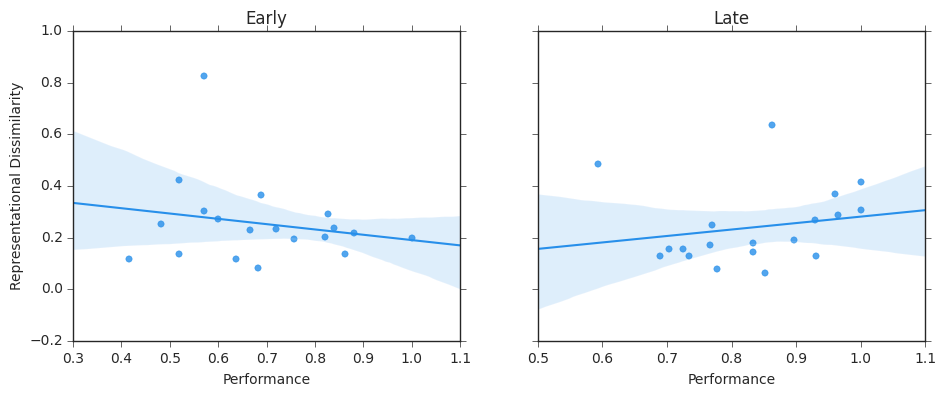

SET 2
Early - Run1: (-0.21462187117202658, 0.37758730580665423)
Late - Run1: (-0.043510957560659314, 0.85961285111664942)


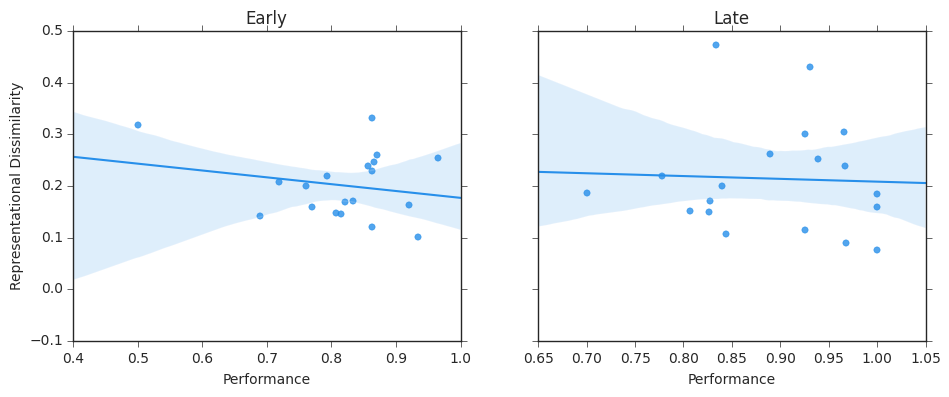

SET 3
Early - Run1: (0.16843810335947679, 0.49062781827483082)
Late - Run1: (-0.29639036991168649, 0.21789426234560544)


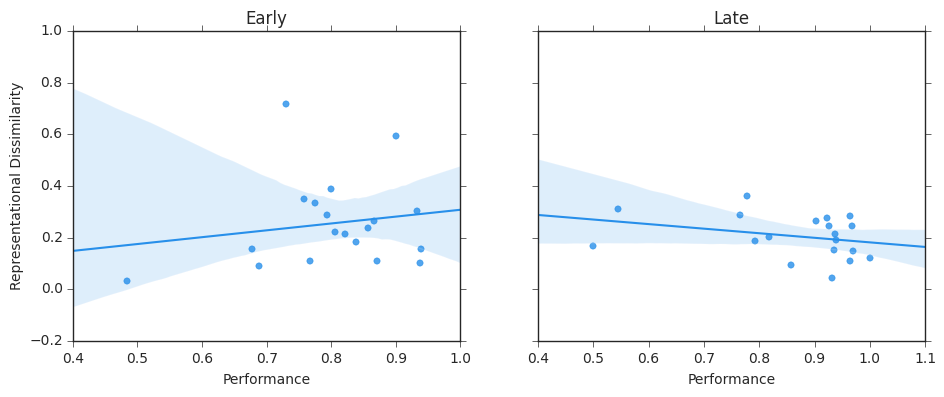

In [12]:
for i in range(3): #iterate through sets
    early_plot = {} #run1 plot
    early_plot['brain'] = corrs_df['hp']['run{0}'.format(i*2+1)] #hippocampus correlations
    early_plot['behavior'] = prop_corr['run{0}'.format(i*2+1)] #Ss proportion of correct responses
    early_plot = pd.DataFrame(early_plot) #convert to pandas dataframe
    late_plot = {} #run2 plot
    late_plot['brain'] = corrs_df['hp']['run{0}'.format(i*2+2)]
    late_plot['behavior'] = prop_corr['run{0}'.format(i*2+2)]
    late_plot = pd.DataFrame(late_plot)
    print "SET {0}".format(i+1)
    #print pearsons r and indicate if significant for Run 1
    if pearsonr(early_plot['brain'],early_plot['behavior'])[:][-1] < 0.0083: #correction for multi comparisons       
        print "Early - Run1:", pearsonr(early_plot['brain'],early_plot['behavior'])[:], "<---- **"
    else: #print statistics only
        print "Early - Run1:", pearsonr(early_plot['brain'],early_plot['behavior'])[:]
    #print pearsons r and indicate if significant for Run 2
    if pearsonr(late_plot['brain'],late_plot['behavior'])[:][-1] < 0.0083:        
        print "Late - Run1:", pearsonr(late_plot['brain'],late_plot['behavior'])[:], "<---- **"
    else: #print statistics only
        print "Late - Run1:", pearsonr(late_plot['brain'],late_plot['behavior'])[:]
    fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (11, 4), sharex = False, sharey = True) #sets subplots
    ax1 = sns.regplot(x = 'behavior', y = 'brain', data = early_plot, color = "#278fea", ax = ax1) #draws first plot
    ax1.set_ylabel('Representational Dissimilarity')
    ax1.set_xlabel('Performance')
    ax1.set_title('Early')
    #ax1.set_ylim(-0.4,0.8)
    ax2 = sns.regplot(x = 'behavior', y = 'brain', data = late_plot, color = "#278fea", ax = ax2) #draws second plot
    ax2.set_ylabel('')
    ax2.set_xlabel('Performance')
    ax2.set_title('Late')
    #plt.savefig("/home/arenf001/figs/RSA2F_hpc_run{0}.png".format(i+1), dpi = 800)
    plt.show() #refreshes drawspace

# Medial Prefrontal Cortex

run1
Mean run1:  0.185458509546
STD run1:  0.12124614249

run2
Mean run2:  0.222039061157
STD run2:  0.155813316555

run3
Mean run3:  0.170943548805
STD run3:  0.0594248846618

run4
Mean run4:  0.261703628851
STD run4:  0.23284919776

run5
Mean run5:  0.214209849897
STD run5:  0.184482296243

run6
Mean run6:  0.198012286111
STD run6:  0.126488943524

Set1 Run1 vs. Run2:
Wicoxon (82.0, 0.60087101157413025)
Cohen's d =  0.36068460084


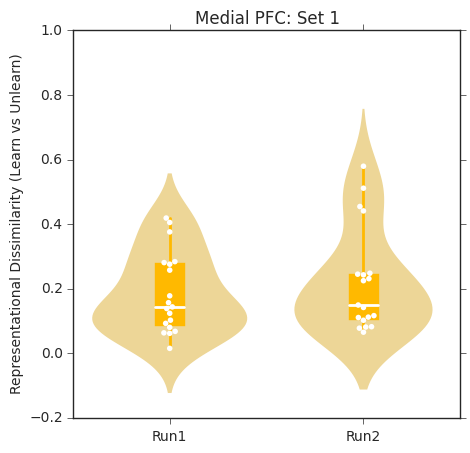

Set2 Run1 vs. Run2:
Wicoxon (58.0, 0.13649771056887278)
Cohen's d =  0.735204363948


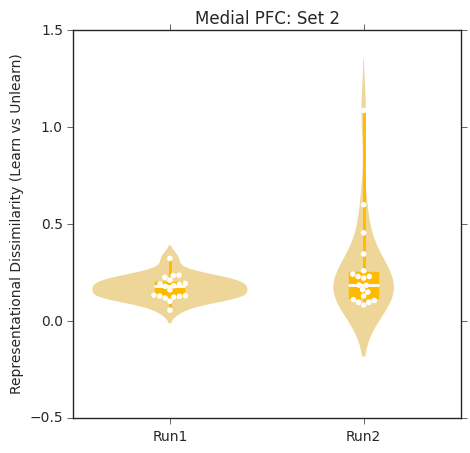

Set3 Run1 vs. Run2:
Wicoxon (89.0, 0.80920396899310776)
Cohen's d =  -0.140964623176


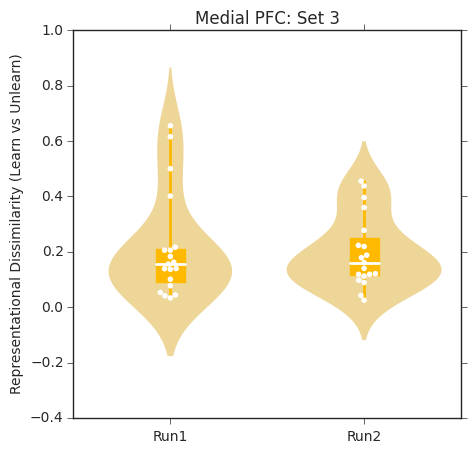

In [13]:
for key in ['run1', 'run2', 'run3', 'run4', 'run5', 'run6']:
    print key
    print "Mean {0}: ".format(key), np.mean(corrs_df['mpfc'][key])
    print "STD {0}: ".format(key), np.std(corrs_df['mpfc'][key])
    print ""
    
for i in range(3):
    N = 2
    conditions = ['Run1', 'Run2']
    allsubjs = [corrs_df['mpfc']['run{0}'.format(i*2+1)], corrs_df['mpfc']['run{0}'.format(i*2+2)]]
    ind = np.arange(N)
    fig, ax = plt.subplots(figsize = (5,5))
    sns.violinplot(data=allsubjs, color="#ffde85", inner=None, linewidth=0, saturation=0.7)
    ax.boxplot(allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,
               showcaps=False, boxprops=dict(color="#ffb900", facecolor="#ffb900"),
               whiskerprops=dict(color="#ffb900", linewidth=2, linestyle = "-"),
               medianprops=dict(color="w", linewidth=2))
    sns.swarmplot(data = allsubjs, size = 4, color = "white", edgecolor = "gray")
    ax.set_xticks(ind)
    ax.set_xticklabels(conditions)
    ax.set_ylabel("Representational Dissimilarity (Learn vs Unlearn)")
    ax.set_title("Medial PFC: Set {0}".format(i+1))
    print 'Set{0} Run1 vs. Run2:'.format(i+1) 
    if stats.shapiro(corrs_df['mpfc']['run{0}'.format(i*2+2)])[1] < 0.049 or stats.shapiro(corrs_df['mpfc']['run{0}'.format(i*2+1)])[1] < 0.049:
        if stats.wilcoxon(corrs_df['mpfc']['run{0}'.format(i*2+2)], corrs_df['mpfc']['run{0}'.format(i*2+1)])[:][-1] < 0.017: #correction for multi comparisons
            print "Wilcoxon", stats.wilcoxon(corrs_df['mpfc']['run{0}'.format(i*2+2)], corrs_df['mpfc']['run{0}'.format(i*2+1)])[:], "<---- **"
        else:
            print "Wicoxon", stats.wilcoxon(corrs_df['mpfc']['run{0}'.format(i*2+2)], corrs_df['mpfc']['run{0}'.format(i*2+1)])[:]
    else:
        if stats.ttest_rel(corrs_df['mpfc']['run{0}'.format(i*2+2)], corrs_df['mpfc']['run{0}'.format(i*2+1)])[:][-1] < 0.017: #correction for multi comparisons
            print "t-test", stats.ttest_rel(corrs_df['mpfc']['run{0}'.format(i*2+2)], corrs_df['mpfc']['run{0}'.format(i*2+1)])[:], "<---- **"
        else:
            print "t-test", stats.ttest_rel(corrs_df['mpfc']['run{0}'.format(i*2+2)], corrs_df['mpfc']['run{0}'.format(i*2+1)])[:]        
    cohens_d = ((np.average(corrs_df['mpfc']['run{0}'.format(i*2+2)]) 
                 - np.average(corrs_df['mpfc']['run{0}'.format(i*2+1)])) 
                / (sqrt((np.std(corrs_df['mpfc']['run{0}'.format(i*2+2)], ddof = 1)) 
                    ** 2 + np.std(corrs_df['mpfc']['run{0}'.format(i*2+1)], ddof = 1) ** 2) / 2))
    print "Cohen's d = ", cohens_d 
    #plt.savefig("/home/arenf001/figs/RSA1F_mpfc_run{0}.png".format(i+1), dpi = 800)
    plt.show() 

SET 1
Early - Run1: (-0.1694696783097282, 0.48793658793107231)
Late - Run1: (0.14926075437688818, 0.54194440936550681)


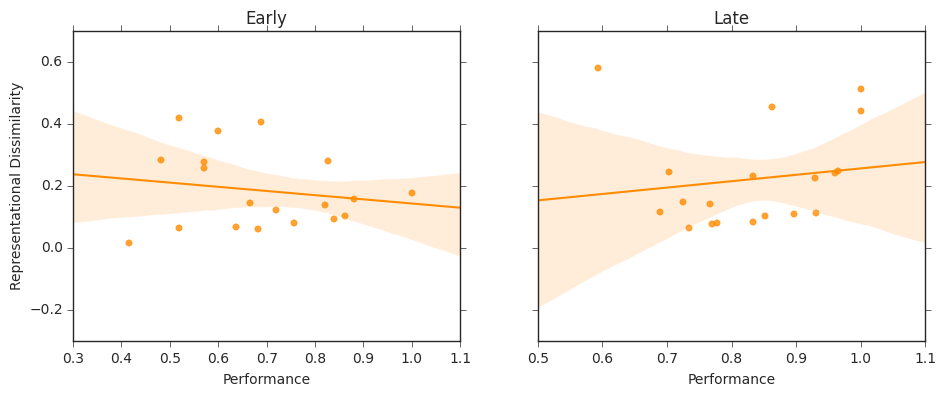

SET 2
Early - Run1: (0.22953603991395793, 0.34450309540826624)
Late - Run1: (-0.037980872934274011, 0.87731772921393614)


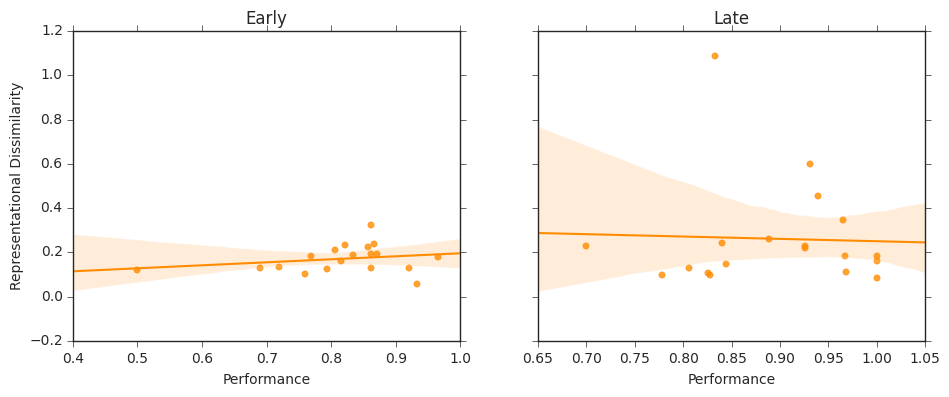

SET 3
Early - Run1: (0.1485183589971984, 0.54397863052816908)
Late - Run1: (0.043318791191028043, 0.8602270566651764)


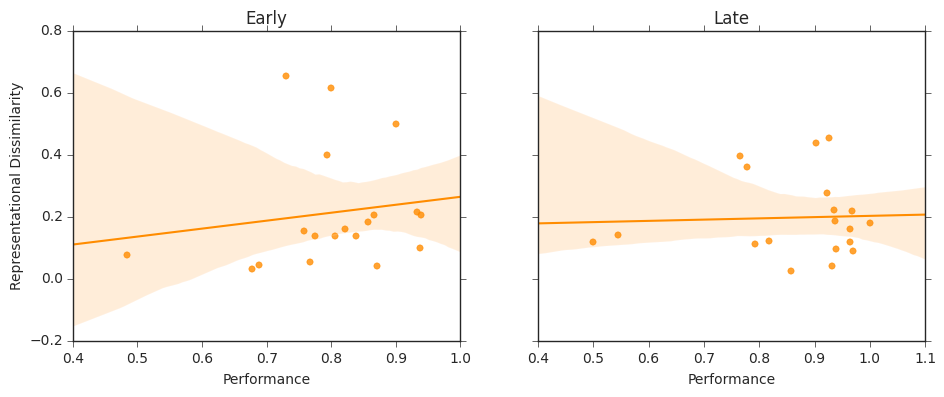

In [28]:
for i in range(3):
    early_plot = {}
    early_plot['brain'] = corrs_df['mpfc']['run{0}'.format(i*2+1)]
    early_plot['behavior'] = prop_corr['run{0}'.format(i*2+1)]
    early_plot = pd.DataFrame(early_plot)
    late_plot = {}
    late_plot['brain'] = corrs_df['mpfc']['run{0}'.format(i*2+2)]
    late_plot['behavior'] = prop_corr['run{0}'.format(i*2+2)]
    late_plot = pd.DataFrame(late_plot)
    print "SET {0}".format(i+1)
    if pearsonr(early_plot['brain'],early_plot['behavior'])[:][-1] < 0.0083: #correction for multi comparisons       
        print "Early - Run1:", pearsonr(early_plot['brain'],early_plot['behavior'])[:], "<---- **"
    else:
        print "Early - Run1:", pearsonr(early_plot['brain'],early_plot['behavior'])[:]
    if pearsonr(late_plot['brain'],late_plot['behavior'])[:][-1] < 0.0083:        
        print "Late - Run1:", pearsonr(late_plot['brain'],late_plot['behavior'])[:], "<---- **"
    else:
        print "Late - Run1:", pearsonr(late_plot['brain'],late_plot['behavior'])[:]
    fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (11, 4), sharex = False, sharey = True)
    ax1 = sns.regplot(x = 'behavior', y = 'brain', data = early_plot, color = "#ff8c00", ax = ax1)
    ax1.set_ylabel('Representational Dissimilarity')
    ax1.set_xlabel('Performance')
    ax1.set_title('Early')
    #ax1.set_ylim(-0.4,0.8)
    ax2 = sns.regplot(x = 'behavior', y = 'brain', data = late_plot, color = "#ff8c00", ax = ax2)
    ax2.set_ylabel('')
    ax2.set_xlabel('Performance')
    ax2.set_title('Late')
    #plt.savefig("/home/arenf001/figs/RSA2F_mpfc_run{0}.png".format(i+1), dpi = 800)
    plt.show()

# Caudate

run1
Mean run1:  0.259180161514
STD run1:  0.125402288231

run2
Mean run2:  0.235732939683
STD run2:  0.133061700923

run3
Mean run3:  0.190706522841
STD run3:  0.0370959676769

run4
Mean run4:  0.213943340276
STD run4:  0.0831373505128

run5
Mean run5:  0.25266010824
STD run5:  0.143383093898

run6
Mean run6:  0.234247000594
STD run6:  0.0881521518248

Set1 Run1 vs. Run2:
Wicoxon (76.0, 0.44450890263539566)
Cohen's d =  -0.249634830754


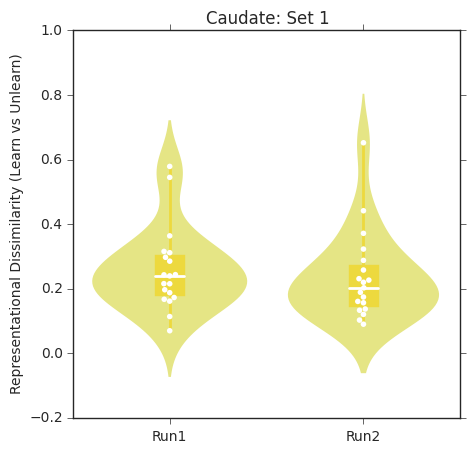

Set2 Run1 vs. Run2:
t-test (1.0012131025865709, 0.3299941431748431)
Cohen's d =  0.49687032512


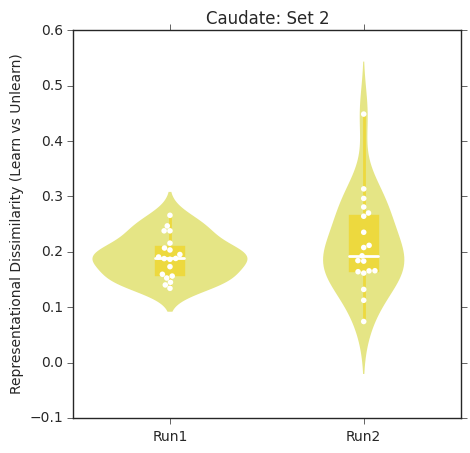

Set3 Run1 vs. Run2:
Wicoxon (85.0, 0.68737361550969722)
Cohen's d =  -0.21295948198


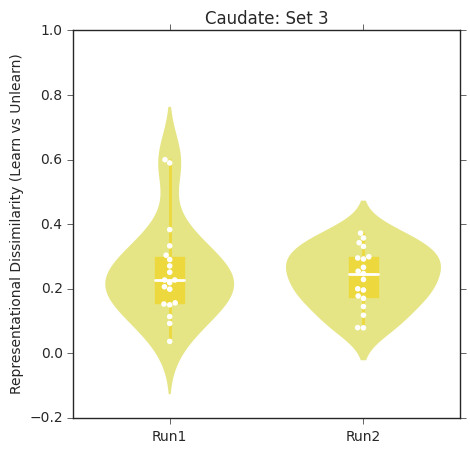

In [27]:
for key in ['run1', 'run2', 'run3', 'run4', 'run5', 'run6']:
    print key
    print "Mean {0}: ".format(key), np.mean(corrs_df['caud'][key])
    print "STD {0}: ".format(key), np.std(corrs_df['caud'][key])
    print ""
    
for i in range(3):
    N = 2
    conditions = ['Run1', 'Run2']
    allsubjs = [corrs_df['caud']['run{0}'.format(i*2+1)], corrs_df['caud']['run{0}'.format(i*2+2)]]
    ind = np.arange(N)
    fig, ax = plt.subplots(figsize = (5,5))
    sns.violinplot(data=allsubjs, color="#fafa70", inner=None, linewidth=0, saturation=0.7)
    ax.boxplot(allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,
               showcaps=False, boxprops=dict(color="#edd93e", facecolor="#edd93e"),
               whiskerprops=dict(color="#edd93e", linewidth=2, linestyle = "-"),
               medianprops=dict(color="w", linewidth=2))
    sns.swarmplot(data = allsubjs, size = 4, color = "white", edgecolor = "gray")
    ax.set_xticks(ind)
    ax.set_xticklabels(conditions)
    ax.set_ylabel("Representational Dissimilarity (Learn vs Unlearn)")
    ax.set_title("Caudate: Set {0}".format(i+1))
    print 'Set{0} Run1 vs. Run2:'.format(i+1) 
    if stats.shapiro(corrs_df['caud']['run{0}'.format(i*2+2)])[1] < 0.049 or stats.shapiro(corrs_df['caud']['run{0}'.format(i*2+1)])[1] < 0.049:
        if stats.wilcoxon(corrs_df['caud']['run{0}'.format(i*2+2)], corrs_df['caud']['run{0}'.format(i*2+1)])[:][-1] < 0.017: #correction for multi comparisons
            print "Wilcoxon", stats.wilcoxon(corrs_df['caud']['run{0}'.format(i*2+2)], corrs_df['caud']['run{0}'.format(i*2+1)])[:], "<---- **"
        else:
            print "Wicoxon", stats.wilcoxon(corrs_df['caud']['run{0}'.format(i*2+2)], corrs_df['caud']['run{0}'.format(i*2+1)])[:]
    else:
        if stats.ttest_rel(corrs_df['caud']['run{0}'.format(i*2+2)], corrs_df['caud']['run{0}'.format(i*2+1)])[:][-1] < 0.017: 
            print "t-test", stats.ttest_rel(corrs_df['caud']['run{0}'.format(i*2+2)], corrs_df['caud']['run{0}'.format(i*2+1)])[:], "<---- **"
        else:
            print "t-test", stats.ttest_rel(corrs_df['caud']['run{0}'.format(i*2+2)], corrs_df['caud']['run{0}'.format(i*2+1)])[:]        
    cohens_d = ((np.average(corrs_df['caud']['run{0}'.format(i*2+2)]) 
                 - np.average(corrs_df['caud']['run{0}'.format(i*2+1)])) 
                / (sqrt((np.std(corrs_df['caud']['run{0}'.format(i*2+2)], ddof = 1)) 
                    ** 2 + np.std(corrs_df['caud']['run{0}'.format(i*2+1)], ddof = 1) ** 2) / 2))
    print "Cohen's d = ", cohens_d 
    #plt.savefig("/home/arenf001/figs/RSA1F_caud_run{0}.png".format(i+1), dpi = 800)
    plt.show() 

SET 1
Early - Run1: (-0.12207853656685574, 0.61857466541770578)
Late - Run1: (0.10915332773794732, 0.65644929077552927)


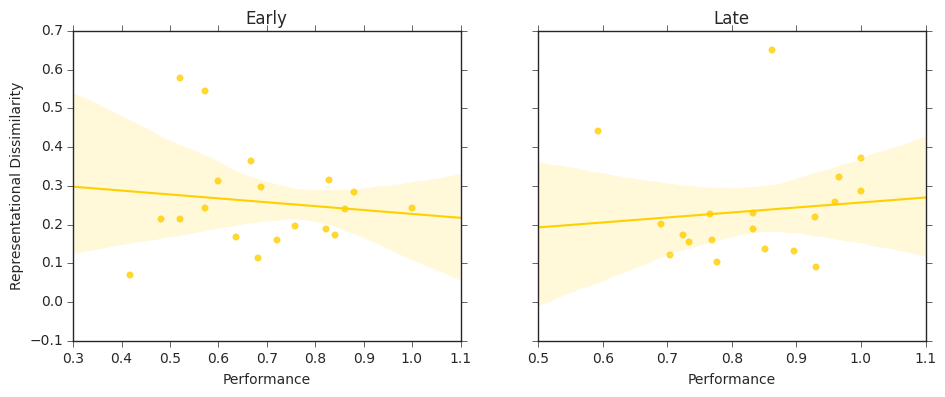

SET 2
Early - Run1: (-0.31792801294582362, 0.18468620599310295)
Late - Run1: (-0.041797564613160934, 0.86509191274069752)


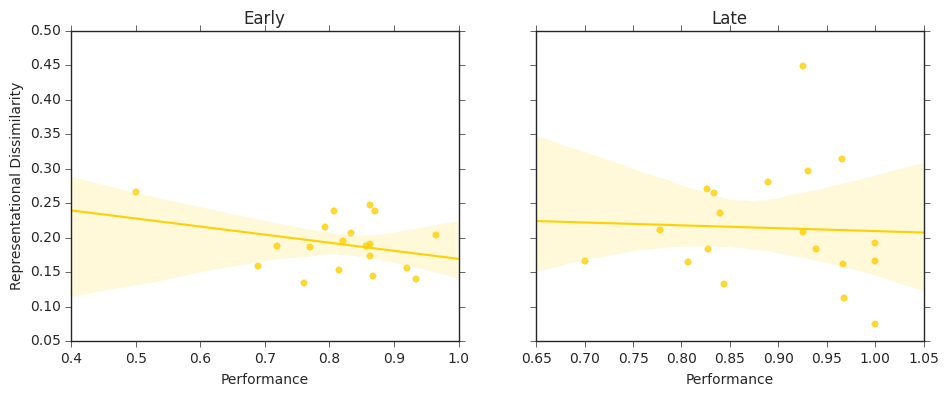

SET 3
Early - Run1: (0.29198932356733781, 0.22513000239543529)
Late - Run1: (-0.29185655704390268, 0.22535067508995971)


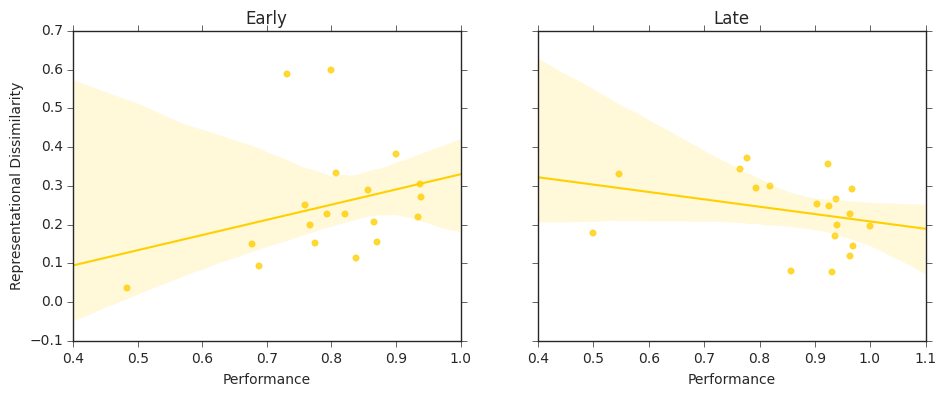

In [26]:
for i in range(3):
    early_plot = {}
    early_plot['brain'] = corrs_df['caud']['run{0}'.format(i*2+1)]
    early_plot['behavior'] = prop_corr['run{0}'.format(i*2+1)]
    early_plot = pd.DataFrame(early_plot)
    late_plot = {}
    late_plot['brain'] = corrs_df['caud']['run{0}'.format(i*2+2)]
    late_plot['behavior'] = prop_corr['run{0}'.format(i*2+2)]
    late_plot = pd.DataFrame(late_plot)
    print "SET {0}".format(i+1)
    if pearsonr(early_plot['brain'],early_plot['behavior'])[:][-1] < 0.0083: #correction for multi comparisons       
        print "Early - Run1:", pearsonr(early_plot['brain'],early_plot['behavior'])[:], "<---- **"
    else:
        print "Early - Run1:", pearsonr(early_plot['brain'],early_plot['behavior'])[:]
    if pearsonr(late_plot['brain'],late_plot['behavior'])[:][-1] < 0.0083:        
        print "Late - Run1:", pearsonr(late_plot['brain'],late_plot['behavior'])[:], "<---- **"
    else:
        print "Late - Run1:", pearsonr(late_plot['brain'],late_plot['behavior'])[:]
    fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (11, 4), sharex = False, sharey = True)
    ax1 = sns.regplot(x = 'behavior', y = 'brain', data = early_plot, color = "#ffd000", ax = ax1)
    ax1.set_ylabel('Representational Dissimilarity')
    ax1.set_xlabel('Performance')
    ax1.set_title('Early')
    #ax1.set_ylim(-0.4,0.8)
    ax2 = sns.regplot(x = 'behavior', y = 'brain', data = late_plot, color = "#ffd000", ax = ax2)
    ax2.set_ylabel('')
    ax2.set_xlabel('Performance')
    ax2.set_title('Late')
    #plt.savefig("/home/arenf001/figs/RSA2F_caud_run{0}.png".format(i+1), dpi = 800)
    plt.show()

# Putamen

run1
Mean run1:  0.253333005466
STD run1:  0.133346842269

run2
Mean run2:  0.227408823214
STD run2:  0.129146968419

run3
Mean run3:  0.220182287066
STD run3:  0.0537568796537

run4
Mean run4:  0.225903239689
STD run4:  0.0883921451912

run5
Mean run5:  0.263287119175
STD run5:  0.128215656774

run6
Mean run6:  0.236445511642
STD run6:  0.0688769887642

Set1 Run1 vs. Run2:
Wicoxon (72.0, 0.35466939531524566)
Cohen's d =  -0.271853458222


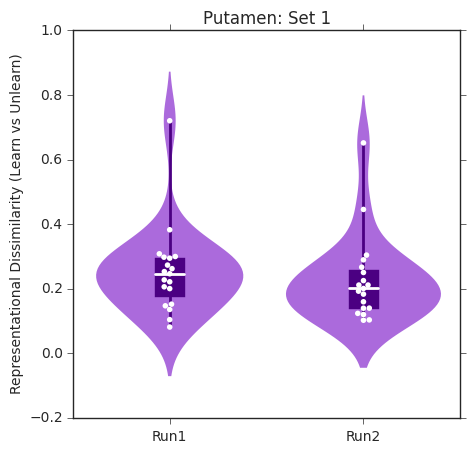

Set2 Run1 vs. Run2:
Wicoxon (93.0, 0.93585203188121813)
Cohen's d =  0.107647903262


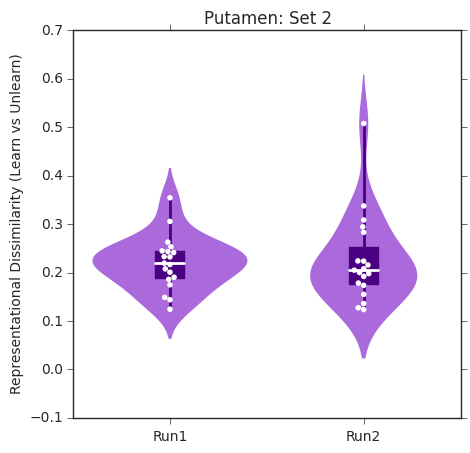

Set3 Run1 vs. Run2:
t-test (-0.85371413059291257, 0.40448187480318776)
Cohen's d =  -0.359005597956


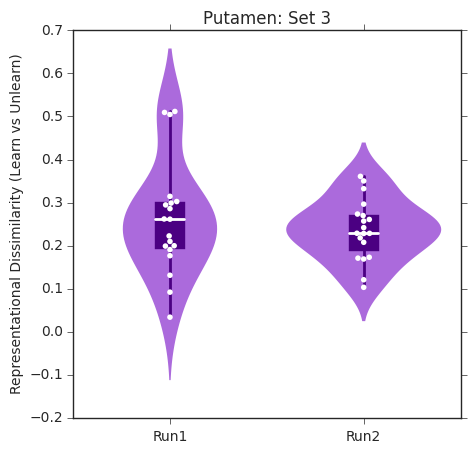

In [17]:
for key in ['run1', 'run2', 'run3', 'run4', 'run5', 'run6']:
    print key
    print "Mean {0}: ".format(key), np.mean(corrs_df['put'][key])
    print "STD {0}: ".format(key), np.std(corrs_df['put'][key])
    print ""
    
for i in range(3):
    N = 2
    conditions = ['Run1', 'Run2']
    allsubjs = [corrs_df['put']['run{0}'.format(i*2+1)], corrs_df['put']['run{0}'.format(i*2+2)]]
    ind = np.arange(N)
    fig, ax = plt.subplots(figsize = (5,5))
    sns.violinplot(data=allsubjs, color="#af52f4", inner=None, linewidth=0, saturation=0.7)
    ax.boxplot(allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,
               showcaps=False, boxprops=dict(color="indigo", facecolor="indigo"),
               whiskerprops=dict(color="indigo", linewidth=2, linestyle = "-"),
               medianprops=dict(color="w", linewidth=2))
    sns.swarmplot(data = allsubjs, size = 4, color = "white", edgecolor = "gray")
    ax.set_xticks(ind)
    ax.set_xticklabels(conditions)
    ax.set_ylabel("Representational Dissimilarity (Learn vs Unlearn)")
    ax.set_title("Putamen: Set {0}".format(i+1))
    print 'Set{0} Run1 vs. Run2:'.format(i+1) 
    if stats.shapiro(corrs_df['put']['run{0}'.format(i*2+2)])[1] < 0.049 or stats.shapiro(corrs_df['put']['run{0}'.format(i*2+1)])[1] < 0.049:
        if stats.wilcoxon(corrs_df['put']['run{0}'.format(i*2+2)], corrs_df['put']['run{0}'.format(i*2+1)])[:][-1] < 0.017: #correction for multi comparisons
            print "Wilcoxon", stats.wilcoxon(corrs_df['put']['run{0}'.format(i*2+2)], corrs_df['put']['run{0}'.format(i*2+1)])[:], "<---- **"
        else:
            print "Wicoxon", stats.wilcoxon(corrs_df['put']['run{0}'.format(i*2+2)], corrs_df['put']['run{0}'.format(i*2+1)])[:]
    else:
        if stats.ttest_rel(corrs_df['put']['run{0}'.format(i*2+2)], corrs_df['put']['run{0}'.format(i*2+1)])[:][-1] < 0.017: #correction for multi comparisons
            print "t-test", stats.ttest_rel(corrs_df['put']['run{0}'.format(i*2+2)], corrs_df['put']['run{0}'.format(i*2+1)])[:], "<---- **"
        else:
            print "t-test", stats.ttest_rel(corrs_df['put']['run{0}'.format(i*2+2)], corrs_df['put']['run{0}'.format(i*2+1)])[:]        
    cohens_d = ((np.average(corrs_df['put']['run{0}'.format(i*2+2)]) 
                 - np.average(corrs_df['put']['run{0}'.format(i*2+1)])) 
                / (sqrt((np.std(corrs_df['put']['run{0}'.format(i*2+2)], ddof = 1)) 
                    ** 2 + np.std(corrs_df['put']['run{0}'.format(i*2+1)], ddof = 1) ** 2) / 2))
    print "Cohen's d = ", cohens_d 
    #plt.savefig("/home/arenf001/figs/RSA1F_put_run{0}.png".format(i+1), dpi = 800)
    plt.show() 

SET 1
Early - Run1: (-0.0919434243570528, 0.70813751562499316)
Late - Run1: (0.045372042264455556, 0.85366846203908164)


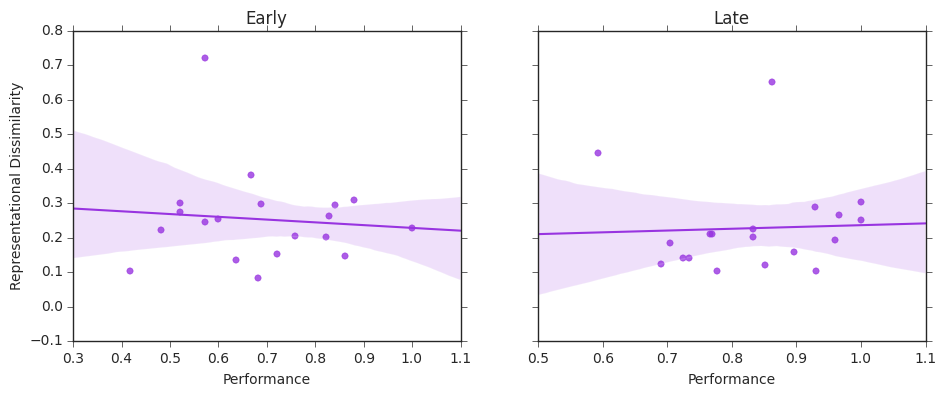

SET 2
Early - Run1: (-0.4719312760664896, 0.041346056674426861)
Late - Run1: (0.081169134310815183, 0.74114760443015371)


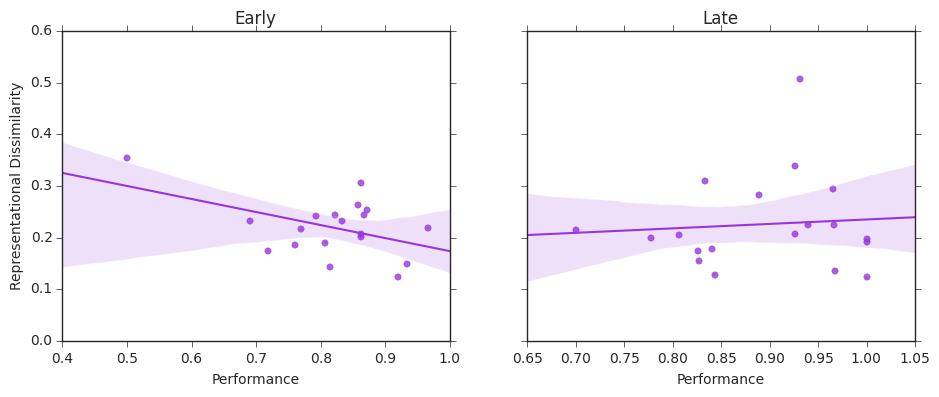

SET 3
Early - Run1: (0.37299003733795366, 0.11575790396235766)
Late - Run1: (-0.13225289343544036, 0.58938945882891636)


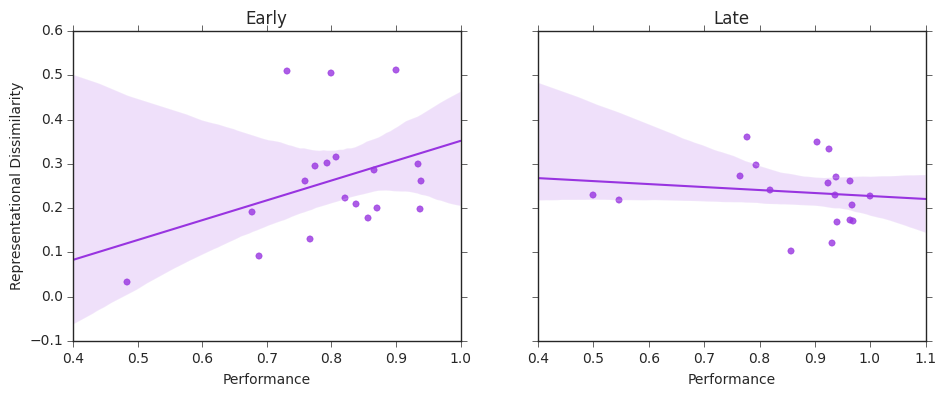

In [23]:
for i in range(3):
    early_plot = {}
    early_plot['brain'] = corrs_df['put']['run{0}'.format(i*2+1)]
    early_plot['behavior'] = prop_corr['run{0}'.format(i*2+1)]
    early_plot = pd.DataFrame(early_plot)
    late_plot = {}
    late_plot['brain'] = corrs_df['put']['run{0}'.format(i*2+2)]
    late_plot['behavior'] = prop_corr['run{0}'.format(i*2+2)]
    late_plot = pd.DataFrame(late_plot)
    print "SET {0}".format(i+1)
    if pearsonr(early_plot['brain'],early_plot['behavior'])[:][-1] < 0.0083: #correction for multi comparisons       
        print "Early - Run1:", pearsonr(early_plot['brain'],early_plot['behavior'])[:], "<---- **"
    else:
        print "Early - Run1:", pearsonr(early_plot['brain'],early_plot['behavior'])[:]
    if pearsonr(late_plot['brain'],late_plot['behavior'])[:][-1] < 0.0083:        
        print "Late - Run1:", pearsonr(late_plot['brain'],late_plot['behavior'])[:], "<---- **"
    else:
        print "Late - Run1:", pearsonr(late_plot['brain'],late_plot['behavior'])[:]
    fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (11, 4), sharex = False, sharey = True)
    ax1 = sns.regplot(x = 'behavior', y = 'brain', data = early_plot, color = "#9834e0", ax = ax1)
    ax1.set_ylabel('Representational Dissimilarity')
    ax1.set_xlabel('Performance')
    ax1.set_title('Early')
    #ax1.set_ylim(-0.4,0.8)
    ax2 = sns.regplot(x = 'behavior', y = 'brain', data = late_plot, color = "#9834e0", ax = ax2)
    ax2.set_ylabel('')
    ax2.set_xlabel('Performance')
    ax2.set_title('Late')
    #plt.savefig("/home/arenf001/figs/RSA2F_put_run{0}.png".format(i+1), dpi = 800)
    plt.show()

# Ventral Occipital

run1
Mean run1:  0.173829259057
STD run1:  0.140255196784

run2
Mean run2:  0.148684931429
STD run2:  0.0889764627464

run3
Mean run3:  0.119256157624
STD run3:  0.0446444827422

run4
Mean run4:  0.146704730235
STD run4:  0.0869258415718

run5
Mean run5:  0.178764540898
STD run5:  0.10651826395

run6
Mean run6:  0.141501762365
STD run6:  0.0709625641645

Set1 Run1 vs. Run2:
Wicoxon (88.0, 0.77817717952283139)
Cohen's d =  -0.294690923302


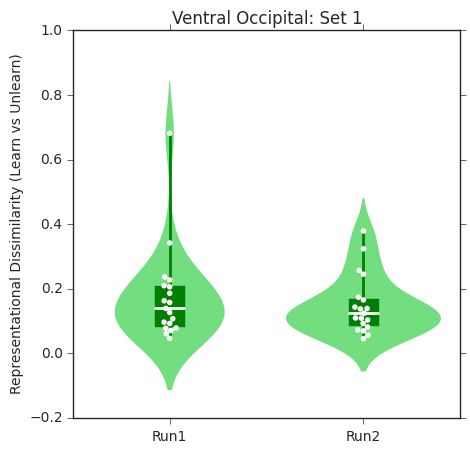

Set2 Run1 vs. Run2:
Wicoxon (64.0, 0.21221142185606556)
Cohen's d =  0.546795580382


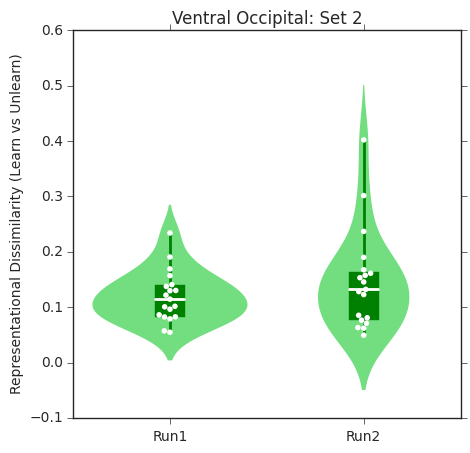

Set3 Run1 vs. Run2:
Wicoxon (61.0, 0.17123878524909952)
Cohen's d =  -0.566739558871


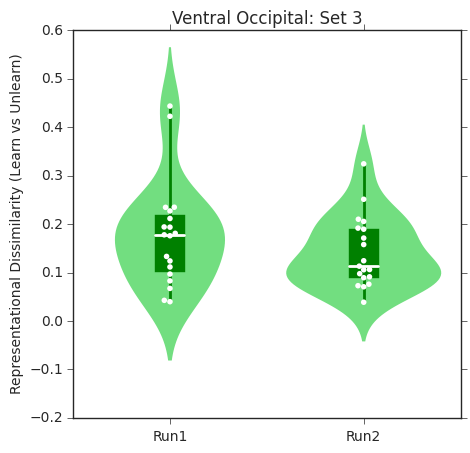

In [19]:
for key in ['run1', 'run2', 'run3', 'run4', 'run5', 'run6']:
    print key
    print "Mean {0}: ".format(key), np.mean(corrs_df['vocc'][key])
    print "STD {0}: ".format(key), np.std(corrs_df['vocc'][key])
    print ""
    
for i in range(3):
    N = 2
    conditions = ['Run1', 'Run2']
    allsubjs = [corrs_df['vocc']['run{0}'.format(i*2+1)], corrs_df['vocc']['run{0}'.format(i*2+2)]]
    ind = np.arange(N)
    fig, ax = plt.subplots(figsize = (5,5))
    sns.violinplot(data=allsubjs, color="#5bf56f", inner=None, linewidth=0, saturation=0.7)
    ax.boxplot(allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,
               showcaps=False, boxprops=dict(color="green", facecolor="green"),
               whiskerprops=dict(color="green", linewidth=2, linestyle = "-"),
               medianprops=dict(color="w", linewidth=2))
    sns.swarmplot(data = allsubjs, size = 4, color = "white", edgecolor = "gray")
    ax.set_xticks(ind)
    ax.set_xticklabels(conditions)
    ax.set_ylabel("Representational Dissimilarity (Learn vs Unlearn)")
    ax.set_title("Ventral Occipital: Set {0}".format(i+1))
    print 'Set{0} Run1 vs. Run2:'.format(i+1) 
    if stats.shapiro(corrs_df['vocc']['run{0}'.format(i*2+2)])[1] < 0.049 or stats.shapiro(corrs_df['vocc']['run{0}'.format(i*2+1)])[1] < 0.049:
        if stats.wilcoxon(corrs_df['vocc']['run{0}'.format(i*2+2)], corrs_df['vocc']['run{0}'.format(i*2+1)])[:][-1] < 0.017: #correction for multi comparisons
            print "Wilcoxon", stats.wilcoxon(corrs_df['vocc']['run{0}'.format(i*2+2)], corrs_df['vocc']['run{0}'.format(i*2+1)])[:], "<---- **"
        else:
            print "Wicoxon", stats.wilcoxon(corrs_df['vocc']['run{0}'.format(i*2+2)], corrs_df['vocc']['run{0}'.format(i*2+1)])[:]
    else:
        if stats.ttest_rel(corrs_df['vocc']['run{0}'.format(i*2+2)], corrs_df['vocc']['run{0}'.format(i*2+1)])[:][-1] < 0.017: #correction for multi comparisons
            print "t-test", stats.ttest_rel(corrs_df['vocc']['run{0}'.format(i*2+2)], corrs_df['vocc']['run{0}'.format(i*2+1)])[:], "<---- **"
        else:
            print "t-test", stats.ttest_rel(corrs_df['vocc']['run{0}'.format(i*2+2)], corrs_df['vocc']['run{0}'.format(i*2+1)])[:]        
    cohens_d = ((np.average(corrs_df['vocc']['run{0}'.format(i*2+2)]) 
                 - np.average(corrs_df['vocc']['run{0}'.format(i*2+1)])) 
                / (sqrt((np.std(corrs_df['vocc']['run{0}'.format(i*2+2)], ddof = 1)) 
                    ** 2 + np.std(corrs_df['vocc']['run{0}'.format(i*2+1)], ddof = 1) ** 2) / 2))
    print "Cohen's d = ", cohens_d 
    #plt.savefig("/home/arenf001/figs/RSA1F_vocc_run{0}.png".format(i+1), dpi = 800)
    plt.show() 

SET 1
Early - Run1: (-0.042830092657923938, 0.86178938898054147)
Late - Run1: (0.22457774279902151, 0.3553100593524951)


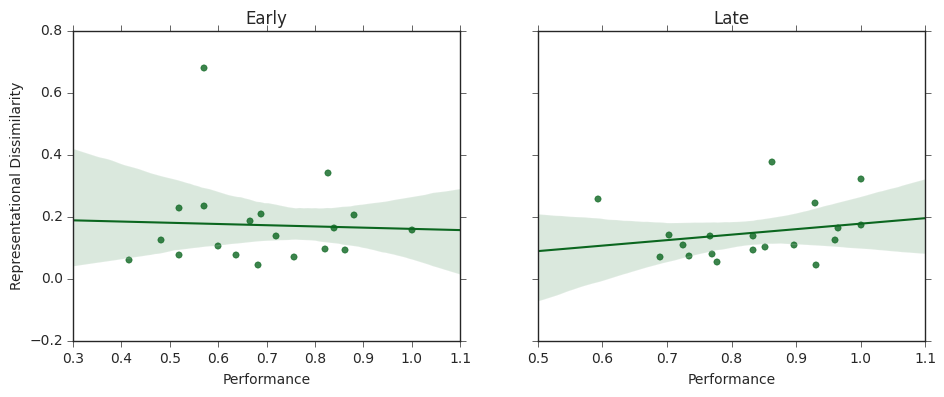

SET 2
Early - Run1: (0.063797987213860111, 0.79526978305618168)
Late - Run1: (0.06951554973622967, 0.77734393947196034)


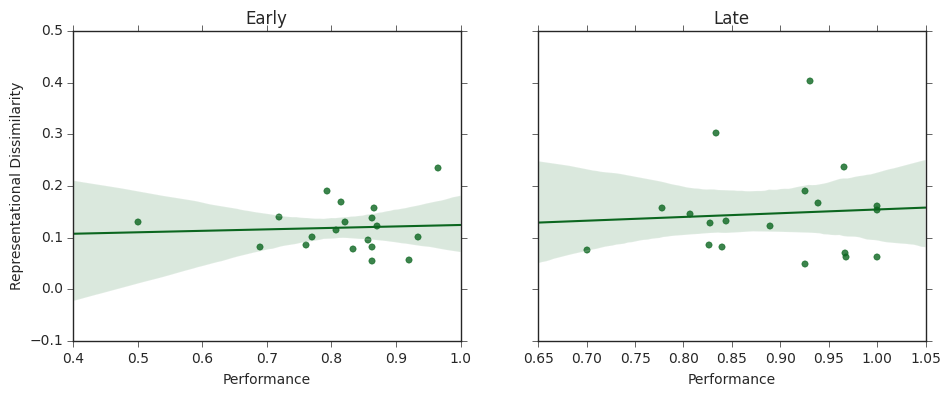

SET 3
Early - Run1: (0.25562092531626285, 0.29085001110353953)
Late - Run1: (0.025137136560025031, 0.91863988300141775)


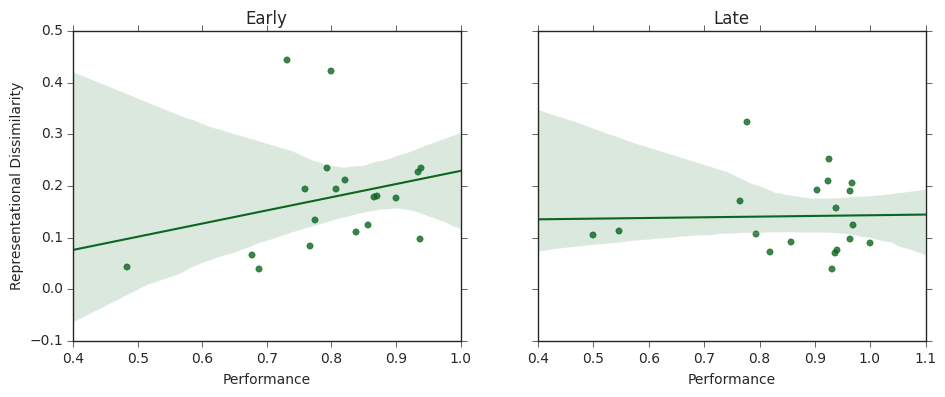

In [25]:
for i in range(3):
    early_plot = {}
    early_plot['brain'] = corrs_df['vocc']['run{0}'.format(i*2+1)]
    early_plot['behavior'] = prop_corr['run{0}'.format(i*2+1)]
    early_plot = pd.DataFrame(early_plot)
    late_plot = {}
    late_plot['brain'] = corrs_df['vocc']['run{0}'.format(i*2+2)]
    late_plot['behavior'] = prop_corr['run{0}'.format(i*2+2)]
    late_plot = pd.DataFrame(late_plot)
    print "SET {0}".format(i+1)
    if pearsonr(early_plot['brain'],early_plot['behavior'])[:][-1] < 0.0083: #correction for multi comparisons       
        print "Early - Run1:", pearsonr(early_plot['brain'],early_plot['behavior'])[:], "<---- **"
    else:
        print "Early - Run1:", pearsonr(early_plot['brain'],early_plot['behavior'])[:]
    if pearsonr(late_plot['brain'],late_plot['behavior'])[:][-1] < 0.0083:        
        print "Late - Run1:", pearsonr(late_plot['brain'],late_plot['behavior'])[:], "<---- **"
    else:
        print "Late - Run1:", pearsonr(late_plot['brain'],late_plot['behavior'])[:]
    fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (11, 4), sharex = False, sharey = True)
    ax1 = sns.regplot(x = 'behavior', y = 'brain', data = early_plot, color = "#0b661f", ax = ax1)
    ax1.set_ylabel('Representational Dissimilarity')
    ax1.set_xlabel('Performance')
    ax1.set_title('Early')
    #ax1.set_ylim(-0.4,0.8)
    ax2 = sns.regplot(x = 'behavior', y = 'brain', data = late_plot, color = "#0b661f", ax = ax2)
    ax2.set_ylabel('')
    ax2.set_xlabel('Performance')
    ax2.set_title('Late')
    #plt.savefig("/home/arenf001/figs/RSA2F_vocc_run{0}.png".format(i+1), dpi = 800)
    plt.show()